# AdaIN Style Transfer 논문 구현

### 출처 : https://github.com/ndb796/Deep-Learning-Paper-Review-and-Practice/blob/master/code_practices/AdaIN_Style_Transfer_Tutorial.ipynb

### 논문 :https://arxiv.org/abs/1703.06868

# 라이브러리 임포트

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
import torchvision.transforms as transforms
from PIL import Image
from IPython.display import Image as display_image

from torchvision.utils import save_image

In [ ]:
a = torch.rand(16, 3, 28, 28)
size1 = a.size()
print(size1)
aa, bb = size1[:2]
print(aa, bb)

torch.Size([16, 3, 28, 28])
16 3


# Adaptive Instance Normalization 정의

## 기존 style transfer 에서는 공분산을 활용한 matrix gram을 사용하였다.
## 결과는 좋았지만 한 이미지를 변형시킬 때마다 시간이 오래걸린다는 단점 발생



## Adain 논문에서는 이러한 단점 극복하기 위해 gram matrix를 정의하는 것이 아닌
## 각 레이어에서 뽑아낸 style feat, content feat을 활용해 독특한 정규화를 진행하는 것이 이 논문의 특징이다.

In [ ]:
def calc_mean_std(feat, eps = 1e-5):
  size = feat.size() #N, C, H, W
  assert (len(size) == 4)
  N, C = size[:2]

  feat_var = feat.view(N, C, -1).var(dim =2) + eps
  feat_std = feat_var.sqrt().view(N, C, 1, 1) #view없으면 (N, C)모양 되지만 instance 위한 변환인듯
  feat_mean = feat.view(N, C, -1).mean(dim = 2).view(N, C, 1, 1) 

  return feat_mean, feat_std

In [ ]:
def adaptive_instance_normalization(content_feat, style_feat): #Adaptive Instance Normalization
  assert (content_feat.size()[:2] == style_feat.size()[:2]) #N, C 수가 같을 때만 진행
  size = content_feat.size()
  style_mean, style_std = calc_mean_std(style_feat)
  content_mean, content_std = calc_mean_std(content_feat)

  normalized_feat = (content_feat - content_mean.expand(size)) / content_std.expand(size)
                    #N, C, 1, 1 크기의 mean 과 std를 expand통해 컨텐츠 이미지 픽셀에 대해 정규화  
  return normalized_feat * style_std.expand(size) + style_mean.expand(size) #정규화 이후 style feature 표준편차를 곱하고 평균을 더한다.

# 사용할 네트워크 준비(vgg를 사용)

## (미리 사전 훈련된 네트워크를 사용하지만 구조를 살펴본다)

In [ ]:
vgg = nn.Sequential(
    nn.Conv2d(3,3, (1, 1)),
    nn.ReflectionPad2d((1, 1, 1, 1)), #Reflection padding : 가장자리 기준으로 input값 패딩영역에 반전하여 복사하여 채움
    nn.Conv2d(3, 64, (3, 3)),
    nn.ReLU(), #기본값: False, inplace 값 True 로 넣으면 결과값을 새로운 변수에 저장하는 것이 아닌 기존의 데이터를 대체

    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 64, (3, 3)),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = (2, 2), stride = (2, 2), padding = (0, 0), ceil_mode = True),  #ceil mode = True면은 부족한 square를 기존의 있는 값으로 채움
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 128, (3, 3)),
    nn.ReLU(), # relu2-1

    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 128, (3, 3)),
    nn.ReLU(), # relu2-2
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 256, (3, 3)),
    nn.ReLU(), # relu3-1

    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(), # relu3-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(), # relu3-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(), # relu3-4
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 512, (3, 3)),
    nn.ReLU(), # relu4-1, 사용하는 마지막 레이어 512개의 채널이 return 된다.
    
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu4-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu4-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu4-4
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu5-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu5-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu5-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU() # relu5-4
)

In [ ]:
decoder = nn.Sequential(
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 256, (3, 3)), #channel의 크기를 줄인다.
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'), #2배로 크기 늘린다.
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 128, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 128, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 64, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 64, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 3, (3, 3)),
)

In [ ]:
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/Ebs6XES37otLgWW5cavCY9YByGOnXJD5wC0WZgQPp8vAJg?download=1 -O decoder.pth
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EXzxBZI0seBFuxucQjlShBEBtM7X5-Lmj-ceqZ5Fu96alA?download=1 -O vgg_normalised.pth


--2022-09-13 08:11:09--  https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/Ebs6XES37otLgWW5cavCY9YByGOnXJD5wC0WZgQPp8vAJg?download=1
Resolving postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)... 13.107.136.9, 13.107.138.9
Connecting to postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)|13.107.136.9|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/dongbinna_postech_ac_kr/Documents/Research/models/AdaIN%20Style%20Transfer/decoder.pth?ga=1 [following]
--2022-09-13 08:11:10--  https://postechackr-my.sharepoint.com/personal/dongbinna_postech_ac_kr/Documents/Research/models/AdaIN%20Style%20Transfer/decoder.pth?ga=1
Reusing existing connection to postechackr-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 14023458 (13M) [application/octet-stream]
Saving to: ‘decoder.pth’

decoder.pth         100%[===================>]  13.37M  4.70MB/s    in 2.8s    

2022-09-13 08:11:14 (4

In [ ]:
decoder.eval() #BatchNorm 이라든가 Dropout layer 등 eval과정에서 사용하지 않아야할 layer들 off
vgg.eval()

vgg_path = './vgg_normalised.pth'
decoder_path = './decoder.pth'
#기존 훈련된 네트워크 사용
decoder.load_state_dict(torch.load(decoder_path)) 
vgg.load_state_dict(torch.load(vgg_path))

<All keys matched successfully>

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #gpu연결

vgg.to(device)
decoder.to(device)
vgg = nn.Sequential(*list(vgg.children())[:31])

In [ ]:
class Net(nn.Module):
  def __init__(self, encoder, decoder):
    super(Net, self).__init__()

    enc_layers = list(encoder.children())
    self.enc_1 = nn.Sequential(*enc_layers[:4])#  *는 여기서 list를 unpacking 용도로 사용된다
    self.enc_2 = nn.Sequential(*enc_layers[4:11])
    self.enc_3 = nn.Sequential(*enc_layers[11:18])
    self.enc_4 = nn.Sequential(*enc_layers[18:31])

    self.decoder = self.decoder
    self.mse_loss = nn.MSELoss()

    for name in ['enc_1', 'enc_2', 'enc_3', 'enc_4']:
      for param in getattr(self, name).parameter():
        param.requires_grad = False


  def encode_with_intermediate(self, input): #스타일 feature추출
    results = [input] #입력값을 넣어준다
    for i in range(4): #각각의 단계를 거치면서 결과물을 넣어준다
      func = getattr(self, 'enc_{}'.format(i+1)) 
      results.append(func(results[-1]))
    return results[1:] #처음 입력값을 제외하고 return 한다


  def encode(self, input):
    for i in range(4):
      input = getattr(self, 'enc_{}'.format(i+1))(input)
    return input #인코더를 거친 아웃풋을 내보낸다.


  def calc_content_loss(self, input, target):
    assert (input.size() == target.size())
    assert (target.requires_grad is False)

    return self.mse_loss(input, target)

  def calc_style_loss(self, input, target):
    assert (input.size() == target.size())
    assert (target.requires_grad is False)
    
    input_mean, input_std = calc_mean_std(input)
    target_mean, target_std = calc_mean_std(target)

    return self.mse_loss(input_mean, target_mean) + self.mse_loss(input_std, target_std)


  def forward(self, content, style, alpha = 1.0):
    assert 0 <= alpha <= 1 #0에 가까울 수록 컨텐츠 비중 높아진다.
    style_feats = self.encode_with_intermetidate(style) #style feat 추출
    content_feats = self.encode(content) #content feat 추출
    t = adaptive_instance_normalization(content_feats, style_feats[-1]) #Adain 을 통해 이미지 담은 feat 추출
    t = alpha * t + (1 - alpha) * content_feats # content, style이미지의 feat담는다

    g_t = self.decoder(t) #결과 이미지
    g_t_feats = self.encode_with_intermediate(g_t) #여러 개의encoder layer에서 뽑아낸 style feat

    loss_c = self.calc_content_loss(g_t_feats[-1], t) #
    loss_s = self.calc_style_loss(g_t_feats[0], style_feats[0])

    for i in range(1, 4):
      loss_s += self.calc_style_loss(g_t_feats[i], style_feats[i])

    return loss_c, loss_s


In [ ]:
!git clone https://github.com/ndb796/Deep-Learning-Paper-Review-and-Practice
%cd Deep-Learning-Paper-Review-and-Practice

Cloning into 'Deep-Learning-Paper-Review-and-Practice'...
remote: Enumerating objects: 462, done.
remote: Counting objects: 100% (201/201), done.
remote: Compressing objects: 100% (136/136), done.
remote: Total 462 (delta 72), reused 190 (delta 65), pack-reused 261
Receiving objects: 100% (462/462), 53.82 MiB | 30.57 MiB/s, done.
Resolving deltas: 100% (152/152), done.
/content/Deep-Learning-Paper-Review-and-Practice


# 이미지 준비

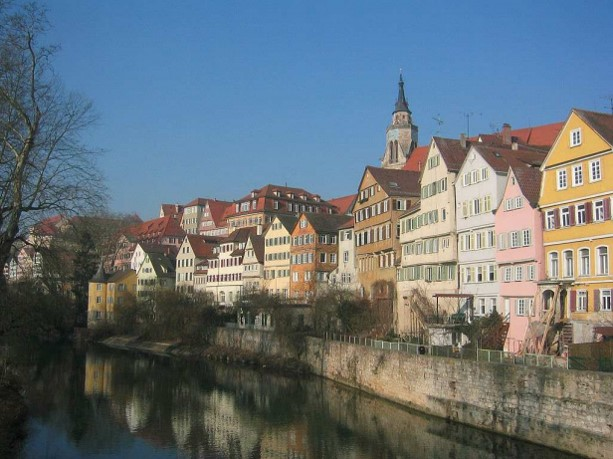

In [ ]:
display_image('./code_practices/images/content_img_1.jpg')

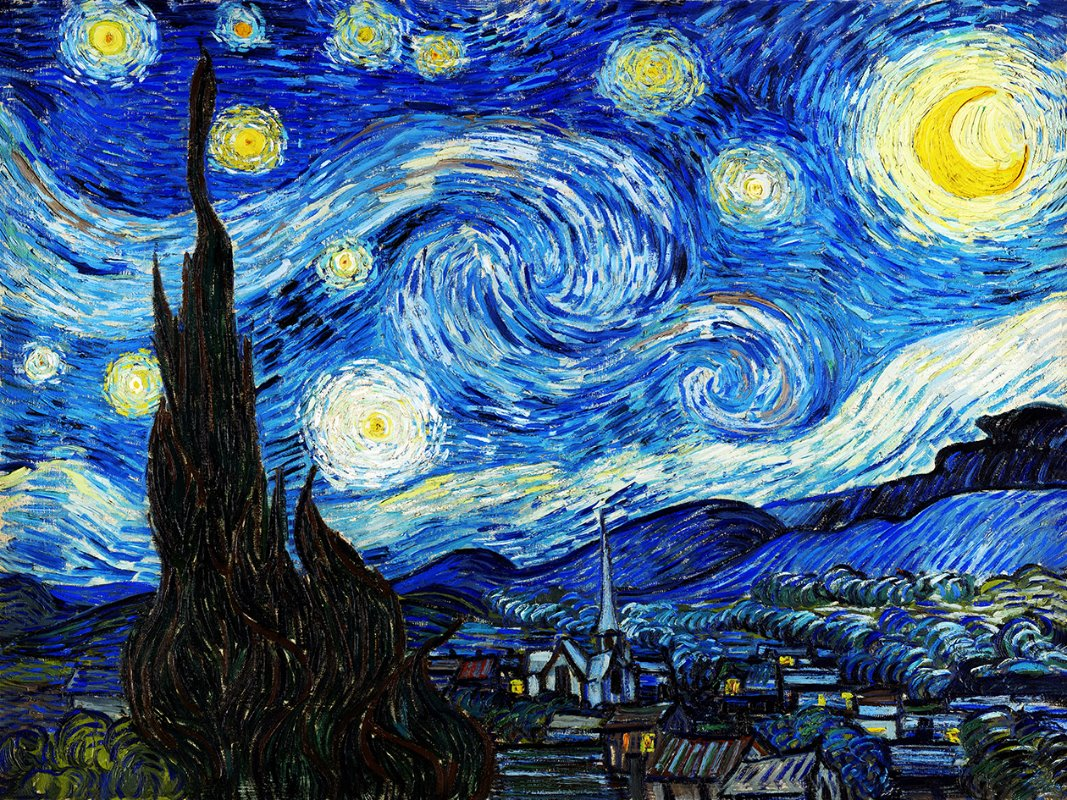

In [ ]:
display_image('./code_practices/images/style_img_1.jpg')

In [ ]:
def style_transfer(vgg, decoder, content, style, alpha = 1.0):
  assert (0 <= alpha <= 1)

  content_f = vgg(content) #encoder에 content 이미지 넣는다
  style_f = vgg(style) #encoder에 style 이미지 넣는다
  feat = adaptive_instance_normalization(content_f, style_f)
  feat = feat * alpha + content_f * (1 - alpha)

  return decoder(feat)

In [ ]:
def test_transform(size = 512):
  transform_list = []
  if size != 0:
    transform_list.append(transforms.Resize(size))
  transform_list.append(transforms.ToTensor())
  transform = transforms.Compose(transform_list)

  return transform

content_tf = test_transform()
style_tf = test_transform()

In [ ]:
content_path = './code_practices/images/content_img_1.jpg'
style_path = './code_practices/images/style_img_1.jpg'

content = content_tf(Image.open(str(content_path)))
style = style_tf(Image.open(str(style_path)))

style = style.to(device).unsqueeze(0)
content = content.to(device).unsqueeze(0)
with torch.no_grad():
    output = style_transfer(vgg, decoder, content, style, alpha=1.0)
output = output.cpu()

save_image(output, 'output.png')

## 결과

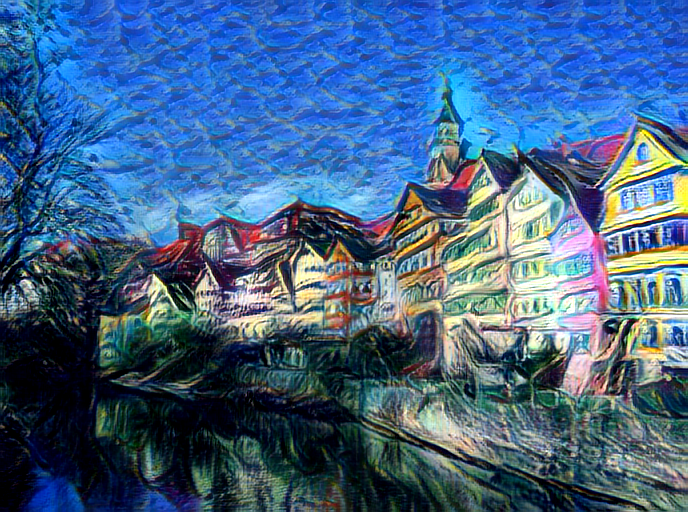

In [ ]:
display_image('./output.png')

## 실험 - 이미지 2개를 섞으면 어떻게 될까

In [ ]:
style_path = '/content/drive/MyDrive/my_img.jpg'
content_path = '/content/drive/MyDrive/외지주2.jpg'

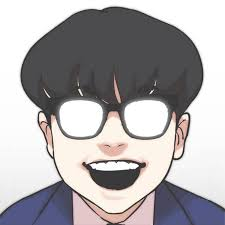

In [ ]:
display_image(content_path)

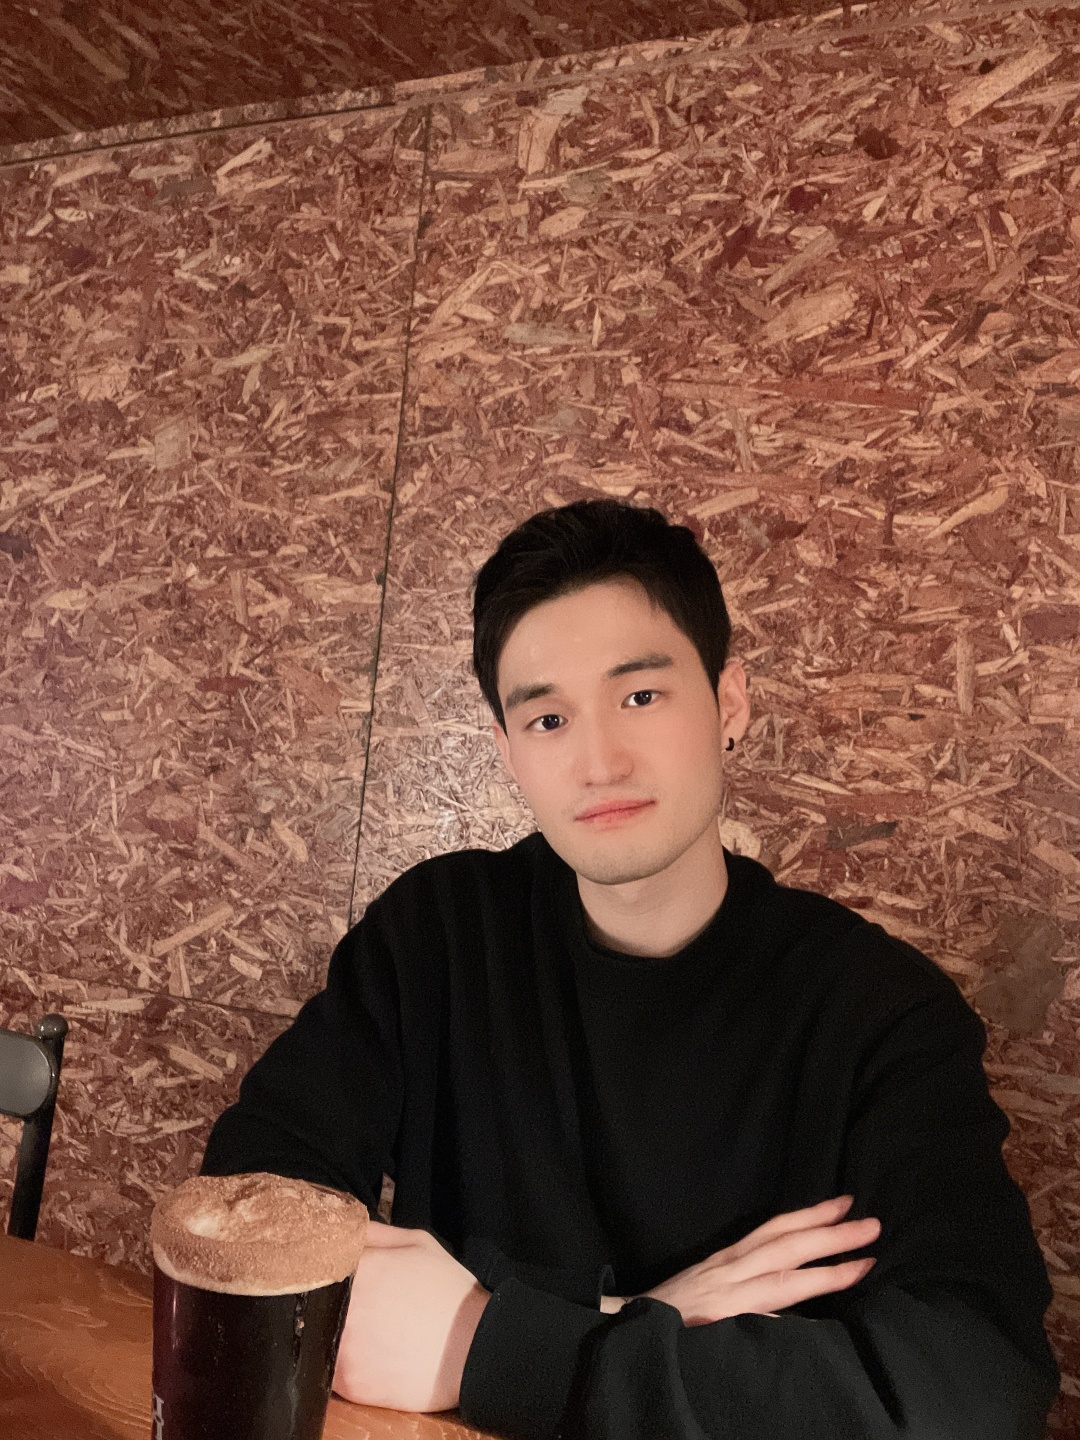

In [ ]:
display_image(style_path)

In [ ]:
import cv2 as cv
import matplotlib.pyplot as plt
import PIL

In [ ]:
def image_loader(path, size):
  trans = transforms.Compose([
      transforms.Resize(size),
      transforms.ToTensor()
  ])
  image = PIL.Image.open(path)
  image = trans(image).unsqueeze(0)
  return image.to(device)

def imshow(img): 
  image = img.cpu().clone() #matplotlib 은 cpu 기반이므로 cpu로 변경
  image = image.squeeze(0)

  image = transforms.ToPILImage()(image) #텐서객체에서 PIL객체로 변경
  plt.imshow(image)
  plt.show()

In [ ]:
style = image_loader(style_path, 256)
content = image_loader(content_path, 256)

print(content.size())
print(style.size())

torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 341, 256])


In [ ]:
Custom_model = nn.Sequential(
    nn.Conv2d(in_channels = 4, out_channels = 3, kernel_size = 1)
)

In [ ]:
print(style.size())
print(content.size())

torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 341, 256])


In [ ]:
style = style.to(device)
content = content.to(device)
with torch.no_grad():
    output = style_transfer(vgg, decoder, content, style, alpha=1)
output = output.cpu()

save_image(output, 'output.png')

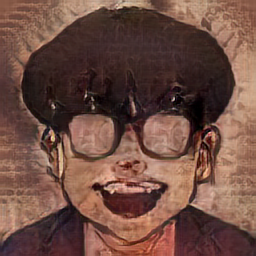

In [ ]:
display_image('./output.png')

In [ ]:
style_path = '/content/drive/MyDrive/mymy.jpg'
content_path = '/content/drive/MyDrive/정해인_img.jpg'

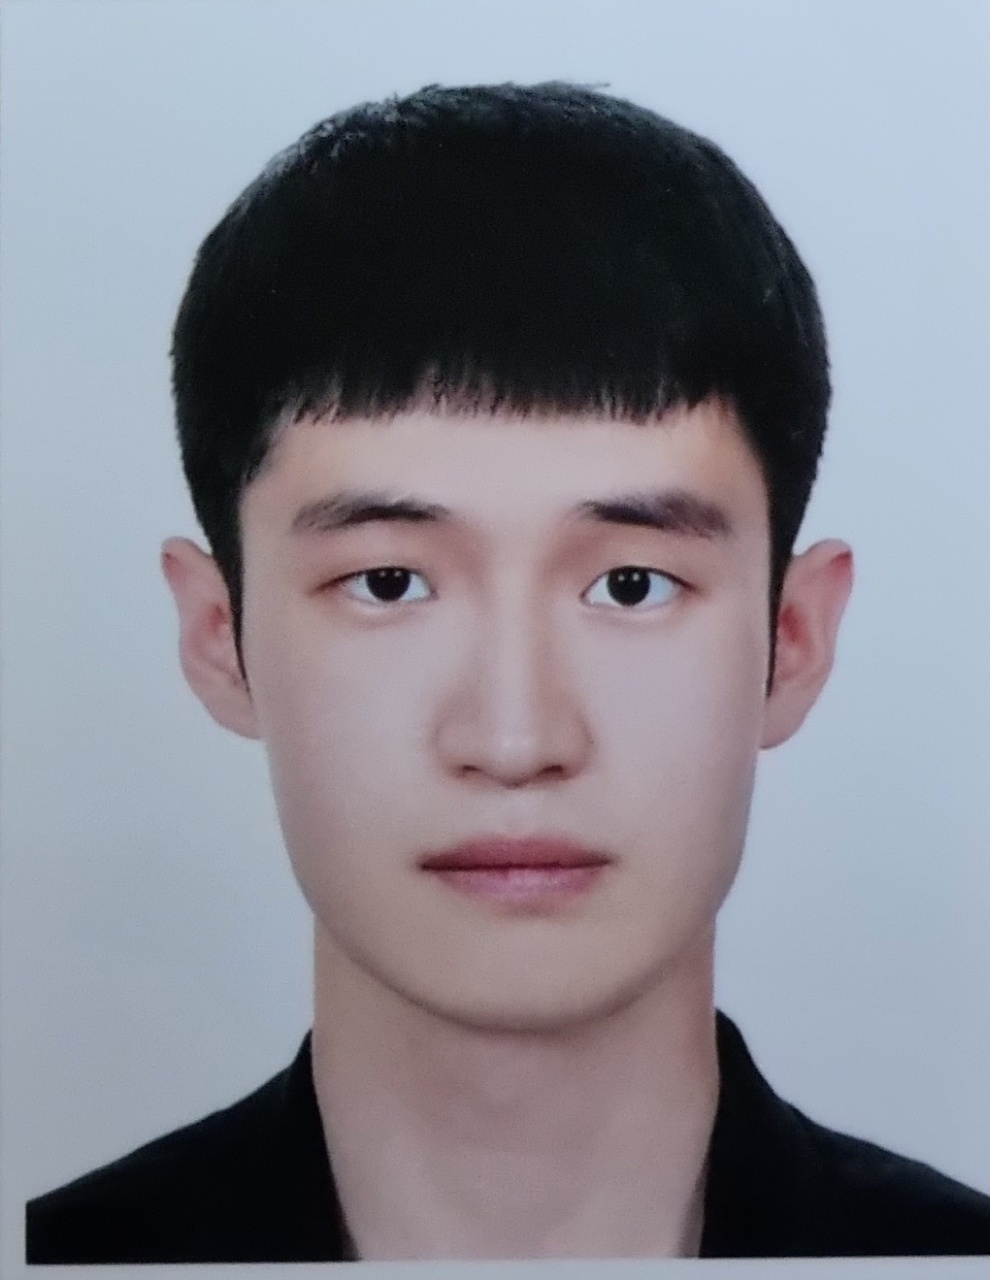

In [ ]:
display_image(style_path)

In [ ]:
style = image_loader(style_path, 512)
content = image_loader(content_path, 512)

print(content.size())
print(style.size())

torch.Size([1, 3, 911, 512])
torch.Size([1, 3, 661, 512])


In [ ]:
style = style.to(device)
content = content.to(device)
with torch.no_grad():
    output = style_transfer(vgg, decoder, content, style, alpha=1)
output = output.cpu()

save_image(output, 'output.png')

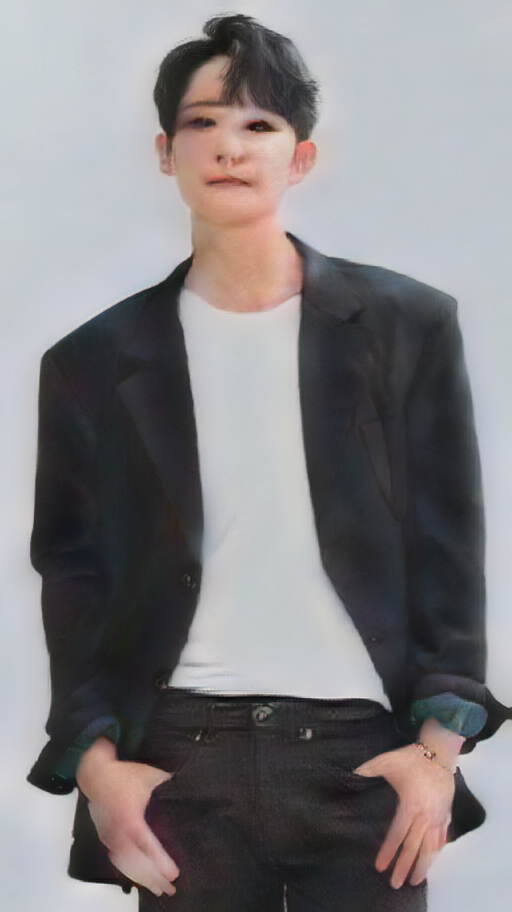

In [ ]:
display_image('./output.png')

## 자연스러운 이미지가 발생되지 않는 것을 확인할 수 있다.